In [1]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

In [3]:
## Models
from langchain_google_genai import  ChatGoogleGenerativeAI
from langchain_groq import  ChatGroq

gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llama_model = ChatGroq(model="llama-3.3-70b-versatile")
deepseek_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.types import Command, interrupt

tavily_tool = TavilySearchResults(max_results=3)


## LinkedIn Agent Graph
<img src="../static/Linkedin_Agents_Graph.png" alt="Graph" width="600">

In [7]:
from operator import add
from pydantic import BaseModel, Field
from typing import Annotated, Literal
from langgraph.graph import MessagesState
## State
class LinkedInGraphState(MessagesState):
    posts: Annotated[list[str], add]
    human_feedback: str
    writer_task: str
    status: Literal["writing", "rewriting", "completed"]

In [8]:
from langchain_core.tools import tool

@tool
class POST_WRITER(BaseModel):
    """The Post Writer Agent who writes a LinkedIn post."""
    task: str = Field(description="The complete details of the task given to this Post Writer Agent.")

In [10]:
from composio_langgraph import Action, ComposioToolSet

composio_toolset = ComposioToolSet(api_key=os.getenv("COMPOSIO_API_KEY"))

linkedin_tools = composio_toolset.get_tools(
    actions=[
        Action.LINKEDIN_GET_MY_INFO,
        Action.LINKEDIN_CREATE_LINKED_IN_POST,
        Action.LINKEDIN_DELETE_LINKED_IN_POST
    ]
)

tools_by_name = {tool.name: tool for tool in linkedin_tools}

In [11]:
main_linkedin_agent = llama_model.bind_tools([POST_WRITER] + linkedin_tools)

In [12]:
[POST_WRITER] + linkedin_tools

[StructuredTool(name='POST_WRITER', description='The Post Writer Agent who writes a LinkedIn post.', args_schema=<class 'langchain_core.utils.pydantic.POST_WRITER'>, func=<class '__main__.POST_WRITER'>),
 StructuredTool(name='LINKEDIN_CREATE_LINKED_IN_POST', description='Create Linked In Post', args_schema=<class 'composio.utils.shared.CreateLinkedInPostRequest'>, func=<function ComposioToolSet._wrap_action.<locals>.function at 0x0000014EB5791760>),
 StructuredTool(name='LINKEDIN_GET_MY_INFO', description='Action To Get Info Of Currently Authenticated Profile From Linked In. This Action Can Be Used To Get The Author Identifier (Author Id) To Create Posts.', args_schema=<class 'composio.utils.shared.GetMyInfoRequest'>, func=<function ComposioToolSet._wrap_action.<locals>.function at 0x0000014EB69C8F40>),
 StructuredTool(name='LINKEDIN_DELETE_LINKED_IN_POST', description='Action To Delete A Post On Linked In.', args_schema=<class 'composio.utils.shared.DeleteLinkedInPostRequest'>, func=<

### Prompts

1. LinkedIn Agent Prompt

In [13]:
LINKEDIN_AGENT_PROMPT = """
# Role
You are a LinkedIn Assistant, specializing in performing LinkedIn-related tasks such as writing, uploading/deleting posts and retrieving user information. Collaborate with your colleague agent, `POST_WRITER`, for posts creation, ensuring tasks are completed efficiently and effectively.

# Task
Execute LinkedIn-related tasks as requested by the user, utilizing your specific tools for each action. If a task involves writing a LinkedIn post, delegate this to POST_WRITER with a clear description of the user's needs. 
Once POST_WRITER completes the post, proceed to upload it to LinkedIn ONLY if user has mentioned to do so. 
For any task that is unclear, engage with the user to gather more details before proceeding.

## Instructions
- Gather complete information about the task from the user. If you are not sure about the task, ask the user for more information.
- Handle tasks related to uploading/deleting LinkedIn posts and retrieving user information.
- Delegate post writing tasks to `POST_WRITER` agent, providing him with a detailed brief from the user.
- Ensure clarity on the user's request by asking for more details if the task is not clear.
- Use the tools provided efficiently to fulfill the user's requests.

# Tools & Agent
You have access to the following tools and an Agent to assist in completing tasks:
1. **POST_WRITER**: A colleague agent who specializes in writing LinkedIn posts according to the user's style and tone, with access to real-time web data.
2. **LINKEDIN_GET_MY_INFO**: Retrieves user information from LinkedIn.
3. **LINKEDIN_DELETE_LINKED_IN_POST**: Deletes a specified LinkedIn post.
4. **LINKEDIN_CREATE_LINKED_IN_POST**: Uploads a new post to LinkedIn.

# Notes
- Prioritize clear communication with the user to ensure tasks are understood and completed according to their needs.
- Do not attempt to write posts yourself; always delegate to `POST_WRITER` for content writing tasks.
- If any function call/tool call fails, retry it.
- If the user has not mentioned to upload the post, do NOT upload it to LinkedIn. Instead, ask them if they want to upload.

"""

2. Post Writer Agent Prompt

In [14]:
POST_WRITER_PROMPT = """
You are a LinkedIn post writer. Your job is to write/enhance a post to sound like me.

## Instructions
1. Post Style & Tone
    - When you are writing the post, make sure it matches the tone, clarity, and engagement level the given example posts.
    - You are given some example posts (within `<post>` tags) written by me. Consider writing the post in the style and tone of given example posts.
    - Generally, the post should be of 50-200 words (unless specified by the user).
2. Post Content
    - Do NOT make up the information, the post must be factually correct.
    - If you don't have enough information to write the post, use tool to gather information from internet.
    - Add a short Post Script (P.S.) in my tone in news related posts.
    - Only add updated & correct information in the post.
3. Post Enhancement
    - If you are provided with a pre-written **post** and **feedback**, enhance the post based on the feedback.
    - Return the enhanced post.
4. Important Note
Do NOT make up the information, the post must be factually correct. Use tools to gather information from internet.
---
Here are some example posts written by me:

<post>
Just in: “Anything on the other side of a screen is at risk of displacement”

Emad Mostaque / Stability AI CEO

I totally agree with this.

What does this mean for a CS student? 

It means opportunity. Feel things you might agree: 

- those who know ai will replace those who dont
- be a generalist: know fe, be, aws, ai, ml
- develop strong people skills. Try to be a loved team player


Knowing ai doesn't mean know how to use tools. It means you can build them. 

You know in movies when a car breaks down and someone “cool” can fix it. 

If you were to crack open an ai today how much can your current toolset take on? 

Know agentic frameworks, infra and ML papers like “code to act” 

alongside abundant full-stack skills. 

Time to become great is now. 

So GTFOL!!!! Common guys who agrees?
</post>

---
<post>
East vs west war is crazy. 

Deepseek was a fine tuned llama model. 

Only $6mn to train. 

For comparison Elons x.ai raised $6bn. 

And sam now raised $500bn for a weird US collab.

Will it be for surveillance as Oracle ceo said. 

Who knows? Thoughts?
</post>

---
<post>
AI engineering in 2025 is less about PyTorch and TensorFlow and more about CrewAI and Langchain. 

It's less about pre-training models from scratch and more about orchestrating agents across different tasks. 

It's less about working with static datasets and more about real-time web crawling and web scraping. 

It's less about black-box AI and more about transparent logging and traceability. 

It's less about large, generic foundation models and more about smaller, task-specific fine-tuned models. 

It's less about spending $$$ on OpenAI API calls and more about being grateful for Chinese models.

All in all seriousness though, 2025 is less about research and more about the application side. 
</post>
---
## Important Note
Just return the post, do NOT return any other text.
"""

In [15]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

def linkedin_agent(
    state: LinkedInGraphState,
) -> Command[Literal["action_executor", "writer_agent", "__end__"]]:
    # Calling the main LinkedIn Agent
    response = main_linkedin_agent.invoke(
        [SystemMessage(content=LINKEDIN_AGENT_PROMPT)] + state["messages"]
    )
    # Check for tool calls
    if hasattr(response, "tool_calls") and response.tool_calls:
        for call in response.tool_calls:
            tool_name = call.get("name")
            args = call.get("args")
            if tool_name == "POST_WRITER":
                # Route to Post Writer Agent
                return Command(
                    update={"writer_task": args["task"], "messages": [response], "status": "writing"}, 
                    goto="writer_agent"
                )
        # Route to Action Executor to Upload/Delete a post
        return Command(
            goto="action_executor",
            update={"messages": [response]}
        )
    # End of Conversation
    return Command(
        update={"messages": [response]},
        goto="__end__"
    )

In [16]:
from langgraph.prebuilt import create_react_agent

def post_writer(
    state: LinkedInGraphState
) -> Command[Literal["human_feedback_node"]]:

    human_feedback = state.get("human_feedback", None)
    task = state['writer_task']

    post_writer_agent = create_react_agent(
        llama_model,
        tools=[tavily_tool],
        prompt=POST_WRITER_PROMPT
        )
    # Check if human feedback is available
    if human_feedback:
        prompt = (
            "## Post \n\n{post}\n\n"
            "## Feedback \n\n{human_feedback}"
        )
        message = HumanMessage(content=prompt.format(post=state["posts"][-1], human_feedback=human_feedback))
    
    else:
        message = HumanMessage(content=task)  # task to write post

    # Invoke the writer agent
    response = post_writer_agent.invoke({"messages": [message]})
    post = response["messages"][-1].content
    # Go to Human Node to get feedback
    return Command(
        update={"posts": [post]},
        goto="human_feedback_node"
    )

In [17]:
def human_feedback(
    state: LinkedInGraphState,
) -> Command[Literal["linkedin_agent", "writer_agent"]]:

    post = state["posts"][-1]  # Most recent version of the post
    action = interrupt(
        {"post": post, "is_approved": "Do you approve the post? [y/n]: "}
    )

    # If user approves the post
    if action["is_approved"].lower().strip() == "y":
        last_message = state["messages"][-1]  # LinkedIn Agent tool call
        tool_messages = []

        for call in last_message.tool_calls:
            tool_name = call.get("name")
            tool_id = call.get("id")
            args = call.get("args")

            if tool_name == "POST_WRITER":
                tool_msg = ToolMessage(
                    name=tool_name,
                    tool_call_id=tool_id,
                    content="Task completed! Here is the post: \n\n" + state["posts"][-1],
                )
                tool_messages.append(tool_msg)

        # Route to Main LinkedIn Agent with tool message
        return Command(
                update={"messages": tool_messages},
                goto="linkedin_agent"
            )
    # If user doesn't approve the post
    elif action["is_approved"].lower().strip() == "n":
        feedback = interrupt("Please provide feedback about the post: ")
        # Route back to writer agent with feedback
        return Command(
            update={"human_feedback": feedback, "status": "rewriting"},
            goto="writer_agent",
        )

In [19]:
def action_node(state: LinkedInGraphState) -> Command[Literal["linkedin_agent"]]:
    
    def execute_tool(tool_call):
        """Executes the given tool call and returns a ToolMessage."""
        tool = tools_by_name[tool_call["name"]]
        output = tool.invoke(tool_call["args"])
        return ToolMessage(content=output, name=tool_call["name"], tool_call_id=tool_call["id"])
    
    result = []
    ## Confirmation messages for tools
    confirmation_messages = {
        "LINKEDIN_CREATE_LINKED_IN_POST": {
            "post": lambda args: args["commentary"],
            "confirmation": "Should I upload the post? [y/n]: "
        },
        "LINKEDIN_DELETE_LINKED_IN_POST": {
            "confirmation": "Do you confirm the action of deleting the post? [y/n]: "
        }
    }
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_name = tool_call["name"]
        
        if tool_name in confirmation_messages:
            confirmation_data = confirmation_messages[tool_name]
            prompt_data = {"confirmation": confirmation_data["confirmation"]}
            if "post" in confirmation_data:
                prompt_data["post"] = confirmation_data["post"](tool_call["args"])
            
            action = interrupt(prompt_data)
            if action["confirmation"].lower().strip() == "y":
                result.append(execute_tool(tool_call))
        else:
            result.append(execute_tool(tool_call))
    # Go to Main LinkedIn Agent
    return Command(
        update={"messages": result, "status": "completed"}, 
        goto="linkedin_agent"
        )


In [20]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("linkedin_agent", linkedin_agent)
builder.add_node("action_executor", action_node)
builder.add_node("writer_agent", post_writer)
builder.add_node("human_feedback_node", human_feedback)


builder.add_edge(START, "linkedin_agent")

## Checkpointer
checkpointer = MemorySaver()
linedin_graph = builder.compile(checkpointer=checkpointer)


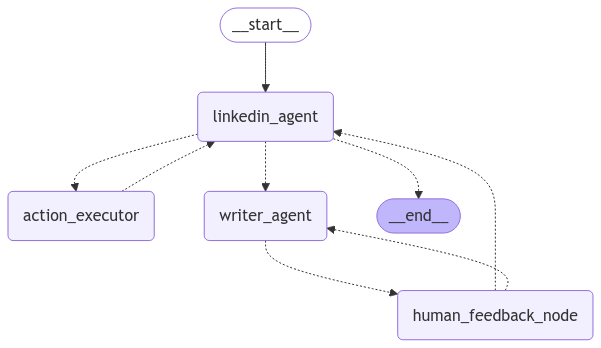

In [21]:
## Display graph
display(Image(linedin_graph.get_graph(xray=1).draw_mermaid_png()))